# QUESTIONS?

1.   The destination and origin code is not restricted to London? The localizer has 17.636 but in the dataset, there are more hexagons
2.   Am I correct to sum the two data frames, Origin and Destination, or am I overlapping the flows?
3.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install Packages
!pip install h3 --quiet
!pip install area --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
pip install matplotlib_scalebar

In [4]:
pip install geodatasets

In [5]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as img
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from geodatasets import get_path
import folium
import statsmodels.api as sm
import h3
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt
import requests
import seaborn as sn

In [6]:
path = '/content/drive/My Drive/Colab/'

In [7]:
# locomizer hexagon grid at level 8
grid8 = gpd.read_file(path + 'grid7.json')

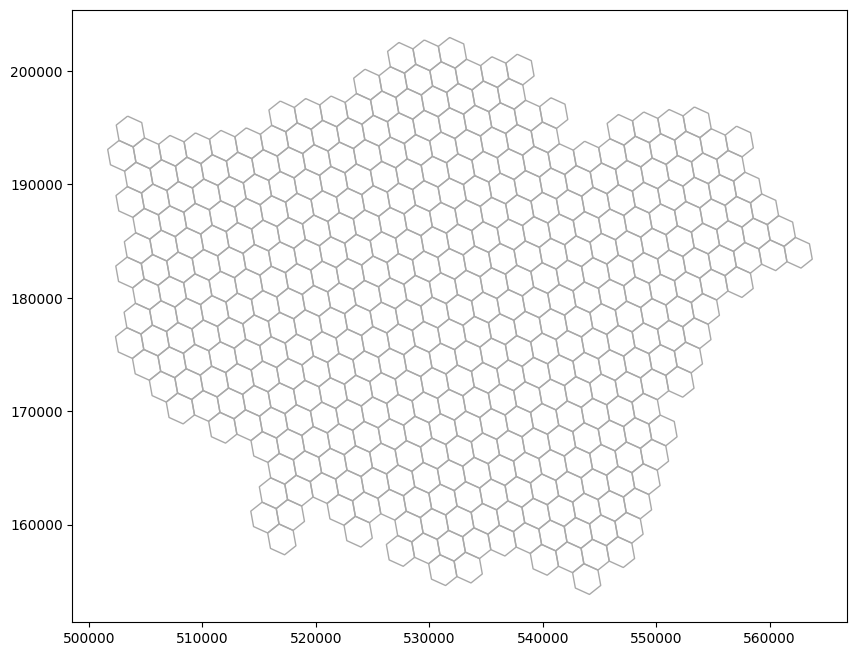

In [8]:
#transform london to BNG
grid8.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
grid8.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

In [9]:
#order it by borough code - *This step will be important later on*
grid8.sort_values(by=["_index"], inplace = True)

#extract the centroids
grid8["Centroids"] = grid8.geometry.centroid



In [10]:
# set the index
London = grid8
London.set_index('_index', inplace=True, drop=True)

#calculate distances from all Hex centroids to all Hex centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

London

,_index,geometry,Centroids
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310)
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811)
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736)
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971)
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092)
...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377)
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413)
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499)
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204)


In [11]:
distances

,Orig,Dest,Dist
0,87194ac00ffffff,87194ac00ffffff,0.000000
1,87194ac00ffffff,87194ac01ffffff,2430.565498
2,87194ac00ffffff,87194ac02ffffff,2251.874795
3,87194ac00ffffff,87194ac03ffffff,2276.072309
4,87194ac00ffffff,87194ac04ffffff,2275.476462
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,10156.365660
172221,87195db6bffffff,87195db5cffffff,8290.118175
172222,87195db6bffffff,87195db5dffffff,6740.416649
172223,87195db6bffffff,87195db69ffffff,2245.531445


In [12]:
od = pd.read_csv(path + "Audience_Profiles_Destination_2023-03-12.tsv", sep="\t", low_memory=False)

In [13]:
#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [14]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)
pivot['ORIGIN_CODE'] = pivot['ORIGIN_CODE'].astype(str)
#check the results

OD3 =  pivot

OD3

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
0,0,89194aca35bffff,0.0,0.0,0.0
1,0,89194ad4013ffff,0.0,0.0,0.0
2,0,89194ad4017ffff,0.0,0.0,0.0
3,0,89194ad406fffff,0.0,0.0,0.0
4,0,89194ad40a7ffff,0.0,0.0,0.0
...,...,...,...,...,...
494618,891976d80b3ffff,89194ac148bffff,23.0,23.0,0.0
494619,891976d80b3ffff,89194ac3267ffff,23.0,0.0,23.0
494620,891976d80b3ffff,89194ac3663ffff,23.0,0.0,23.0
494621,891976d80b3ffff,89194ac366fffff,23.0,0.0,23.0


In [15]:
unique_strings = OD3['ORIGIN_CODE'].unique()
unique_strings2 = OD3['DESTINATION_CODE'].unique()

count_total = len(unique_strings)
print(count_total)

count_total2 = len(unique_strings2)
print(count_total2)

58368
16112


In [16]:
unique_strings

array(['0', '8909a6b65dbffff', '89182180447ffff', ..., '891976d8037ffff',
       '891976d80b3ffff', '891976d81cbffff'], dtype=object)

In [17]:
# Remove rows with value '0' in 'ORIGIN_CODE'
test = OD3[OD3['ORIGIN_CODE'] != '0']

In [18]:
unique_strings3 = test['ORIGIN_CODE'].unique()

count_total3 = len(unique_strings3)
count_total3

58367

In [19]:
count_total3

58367

In [20]:
od = pd.read_csv(path + "Audience_Profiles_Origin_2023-03-12.tsv", sep="\t", low_memory=False)

In [21]:
#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [22]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
#OD4 = pivot[pivot['DESTINATION_CODE'] != '0']

#check the results
OD4 = pivot
OD4

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS,TRANSIENTS
0,89194ac0003ffff,89194ac0003ffff,92.0,92.0,0.0
1,89194ac0003ffff,89194ac0403ffff,23.0,0.0,23.0
2,89194ac0003ffff,89194ac040bffff,23.0,0.0,23.0
3,89194ac0003ffff,89194ac0473ffff,23.0,0.0,23.0
4,89194ac0003ffff,89194ac0613ffff,23.0,0.0,23.0
...,...,...,...,...,...
232549,89195db6bbbffff,89194e79dbbffff,46.0,0.0,46.0
232550,89195db6bbbffff,89195da6137ffff,0.0,23.0,-23.0
232551,89195db6bbbffff,89195db6b17ffff,92.0,0.0,92.0
232552,89195db6bbbffff,89195db6bbbffff,92.0,0.0,92.0


In [23]:
unique_strings = OD4['ORIGIN_CODE'].unique()
unique_strings2 = OD4['DESTINATION_CODE'].unique()

count_total = len(unique_strings)
print(count_total)

count_total2 = len(unique_strings2)
print(count_total2)

17636
30208


In [24]:
# Remove rows with value '0' in 'ORIGIN_CODE'
OD4 = OD4[OD4['DESTINATION_CODE'] != '0']

# Remove rows with value '0' in 'ORIGIN_CODE'
OD3 = OD3[OD3['ORIGIN_CODE'] != '0']

In [25]:
OD3.drop(columns=['ALL','WORKERS'], inplace=True)


<ipython-input-25-3f5cad0c7a99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD3.drop(columns=['ALL','WORKERS'], inplace=True)


In [26]:
OD4.drop(columns=['ALL','WORKERS'], inplace=True)

<ipython-input-26-d58c640083ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD4.drop(columns=['ALL','WORKERS'], inplace=True)


In [27]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
merged_df = pd.merge(OD3, OD4, on=['ORIGIN_CODE', 'DESTINATION_CODE'], how= 'outer').fillna(0)

In [28]:
merged_df

,ORIGIN_CODE,DESTINATION_CODE,TRANSIENTS_x,TRANSIENTS_y
0,8909a6b65dbffff,89194ada017ffff,0.0,0.0
1,89182180447ffff,89194ada097ffff,23.0,0.0
2,89182180447ffff,89195da490fffff,23.0,0.0
3,89182180447ffff,89195da4b63ffff,23.0,0.0
4,89182180697ffff,89194ad2933ffff,23.0,0.0
...,...,...,...,...
530294,89195db6bbbffff,89194e78817ffff,0.0,46.0
530295,89195db6bbbffff,89194e78e27ffff,0.0,46.0
530296,89195db6bbbffff,89194e79d43ffff,0.0,46.0
530297,89195db6bbbffff,89194e79dbbffff,0.0,46.0


In [29]:
# Create a new column 'check' based on the condition
merged_df['check'] = merged_df['TRANSIENTS_x'] == merged_df['TRANSIENTS_y']

# Convert boolean values to 'True' or 'False'
merged_df['check'] = merged_df['check'].astype(bool)

merged_df

,ORIGIN_CODE,DESTINATION_CODE,TRANSIENTS_x,TRANSIENTS_y,check
0,8909a6b65dbffff,89194ada017ffff,0.0,0.0,True
1,89182180447ffff,89194ada097ffff,23.0,0.0,False
2,89182180447ffff,89195da490fffff,23.0,0.0,False
3,89182180447ffff,89195da4b63ffff,23.0,0.0,False
4,89182180697ffff,89194ad2933ffff,23.0,0.0,False
...,...,...,...,...,...
530294,89195db6bbbffff,89194e78817ffff,0.0,46.0,False
530295,89195db6bbbffff,89194e78e27ffff,0.0,46.0,False
530296,89195db6bbbffff,89194e79d43ffff,0.0,46.0,False
530297,89195db6bbbffff,89194e79dbbffff,0.0,46.0,False


In [30]:
uniq = merged_df['check'].unique()
uniq

array([ True, False])

In [31]:
# Filter the DataFrame to show only rows where 'check' is False
filtered_df = merged_df[merged_df['check'] == False]
filtered_df

,ORIGIN_CODE,DESTINATION_CODE,TRANSIENTS_x,TRANSIENTS_y,check
1,89182180447ffff,89194ada097ffff,23.0,0.0,False
2,89182180447ffff,89195da490fffff,23.0,0.0,False
3,89182180447ffff,89195da4b63ffff,23.0,0.0,False
4,89182180697ffff,89194ad2933ffff,23.0,0.0,False
5,89182188bb3ffff,89194ad14c7ffff,23.0,0.0,False
...,...,...,...,...,...
530294,89195db6bbbffff,89194e78817ffff,0.0,46.0,False
530295,89195db6bbbffff,89194e78e27ffff,0.0,46.0,False
530296,89195db6bbbffff,89194e79d43ffff,0.0,46.0,False
530297,89195db6bbbffff,89194e79dbbffff,0.0,46.0,False


In [32]:
# Assuming your DataFrame is named 'df'
filter_df = filtered_df[(filtered_df['TRANSIENTS_x'] > 0) & (filtered_df['TRANSIENTS_y'] > 0)]
filter_df

,ORIGIN_CODE,DESTINATION_CODE,TRANSIENTS_x,TRANSIENTS_y,check
116743,89194ad14c7ffff,89194ad3683ffff,254.0,277.0,False


In [33]:
# Create a new column based on conditions
merged_df['FLOWS'] = np.where(
    (merged_df['TRANSIENTS_x'] != merged_df['TRANSIENTS_y']) &
    (merged_df['TRANSIENTS_x'] > 0) & (merged_df['TRANSIENTS_y'] > 0),
    np.maximum(merged_df['TRANSIENTS_x'], merged_df['TRANSIENTS_y']),  # Choose the higher value
    np.where(
        (merged_df['TRANSIENTS_x'] != merged_df['TRANSIENTS_y']) &
        ((merged_df['TRANSIENTS_x'] < 0) | (merged_df['TRANSIENTS_y'] < 0)),
        np.maximum(merged_df['TRANSIENTS_x'], merged_df['TRANSIENTS_y']),  # Choose the positive value
        np.where(
            merged_df['TRANSIENTS_x'] == merged_df['TRANSIENTS_y'],
            merged_df['TRANSIENTS_y'],  # Choose either value, they are equal
            merged_df['TRANSIENTS_x'] + merged_df['TRANSIENTS_y']  # Add both values if none of the conditions are met
        )
    )
)


In [34]:
merged_df

,ORIGIN_CODE,DESTINATION_CODE,TRANSIENTS_x,TRANSIENTS_y,check,FLOWS
0,8909a6b65dbffff,89194ada017ffff,0.0,0.0,True,0.0
1,89182180447ffff,89194ada097ffff,23.0,0.0,False,23.0
2,89182180447ffff,89195da490fffff,23.0,0.0,False,23.0
3,89182180447ffff,89195da4b63ffff,23.0,0.0,False,23.0
4,89182180697ffff,89194ad2933ffff,23.0,0.0,False,23.0
...,...,...,...,...,...,...
530294,89195db6bbbffff,89194e78817ffff,0.0,46.0,False,46.0
530295,89195db6bbbffff,89194e78e27ffff,0.0,46.0,False,46.0
530296,89195db6bbbffff,89194e79d43ffff,0.0,46.0,False,46.0
530297,89195db6bbbffff,89194e79dbbffff,0.0,46.0,False,46.0


In [35]:
merged_df.drop(columns=['TRANSIENTS_x','TRANSIENTS_y','check'], inplace=True)

In [36]:
merged_df

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,8909a6b65dbffff,89194ada017ffff,0.0
1,89182180447ffff,89194ada097ffff,23.0
2,89182180447ffff,89195da490fffff,23.0
3,89182180447ffff,89195da4b63ffff,23.0
4,89182180697ffff,89194ad2933ffff,23.0
...,...,...,...
530294,89195db6bbbffff,89194e78817ffff,46.0
530295,89195db6bbbffff,89194e78e27ffff,46.0
530296,89195db6bbbffff,89194e79d43ffff,46.0
530297,89195db6bbbffff,89194e79dbbffff,46.0


In [37]:
OD = merged_df

In [38]:
# Assuming 'ORIGIN_CODE' and 'DESTINATION_CODE' are H3 level 9 indices (hexagons)
# You can create a new column with H3 level 8 indices based on the level 9 indices
OD['ORIGIN_CODE_LEVEL_8'] = OD['ORIGIN_CODE'].apply(lambda x: h3.h3_to_parent(x, 7))
OD['DESTINATION_CODE_LEVEL_8'] = OD['DESTINATION_CODE'].apply(lambda x: h3.h3_to_parent(x, 7))

# Group by the new level 8 indices and sum the 'FLOWS' values
aggregated_OD = OD.groupby(['ORIGIN_CODE_LEVEL_8', 'DESTINATION_CODE_LEVEL_8'])['FLOWS'].sum().reset_index()

# Drop the intermediate columns if you don't need them anymore
# aggregated_OD.drop(['ORIGIN_CODE','DESTINATION_CODE'], axis=1)

# Rename the columns to match your original DataFrame if necessary
aggregated_OD.rename(columns={'ORIGIN_CODE_LEVEL_8': 'ORIGIN_CODE', 'DESTINATION_CODE_LEVEL_8': 'DESTINATION_CODE'}, inplace=True)

# Now, aggregated_OD contains the desired result with H3 level 8 indices and aggregated 'FLOWS' values
aggregated_OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,8709a6b65ffffff,87194ada0ffffff,0.0
1,871821804ffffff,87194ada0ffffff,23.0
2,871821804ffffff,87195da49ffffff,23.0
3,871821804ffffff,87195da4bffffff,23.0
4,871821806ffffff,87194ad29ffffff,23.0
...,...,...,...
174386,871976d80ffffff,87194ac14ffffff,92.0
174387,871976d80ffffff,87194ac32ffffff,23.0
174388,871976d80ffffff,87194ac36ffffff,46.0
174389,871976d80ffffff,87195daf3ffffff,23.0


In [39]:
aggregated_OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,8709a6b65ffffff,87194ada0ffffff,0.0
1,871821804ffffff,87194ada0ffffff,23.0
2,871821804ffffff,87195da49ffffff,23.0
3,871821804ffffff,87195da4bffffff,23.0
4,871821806ffffff,87194ad29ffffff,23.0
...,...,...,...
174386,871976d80ffffff,87194ac14ffffff,92.0
174387,871976d80ffffff,87194ac32ffffff,23.0
174388,871976d80ffffff,87194ac36ffffff,46.0
174389,871976d80ffffff,87195daf3ffffff,23.0


In [40]:
# Replace negative values with zero in the 'FLOWS' column
aggregated_OD.loc[aggregated_OD['FLOWS'] < 0, 'FLOWS'] = 0

In [41]:
distances = distances.rename(columns={'Orig': 'ORIGIN_CODE',
                                      'Dest': 'DESTINATION_CODE'})

In [42]:
distances

,ORIGIN_CODE,DESTINATION_CODE,Dist
0,87194ac00ffffff,87194ac00ffffff,0.000000
1,87194ac00ffffff,87194ac01ffffff,2430.565498
2,87194ac00ffffff,87194ac02ffffff,2251.874795
3,87194ac00ffffff,87194ac03ffffff,2276.072309
4,87194ac00ffffff,87194ac04ffffff,2275.476462
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,10156.365660
172221,87195db6bffffff,87195db5cffffff,8290.118175
172222,87195db6bffffff,87195db5dffffff,6740.416649
172223,87195db6bffffff,87195db69ffffff,2245.531445


In [51]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
OD_final = pd.merge(distances, aggregated_OD, on=['ORIGIN_CODE', 'DESTINATION_CODE'], how= 'left').fillna(0)

In [52]:
OD_final.drop(columns=['Dist'], inplace=True)

In [53]:
# Calculate statistics for the "FLOWS" column
statistics = {
    'N': OD_final['FLOWS'].count(),
    'mean': OD_final['FLOWS'].mean(),
    'minimum': OD_final['FLOWS'].min(),
    'maximum': OD_final['FLOWS'].max(),
    'std_deviation': OD_final['FLOWS'].std(),
    'variance': OD_final['FLOWS'].var()
}

# Create a new DataFrame from the statistics dictionary
statistics_df = pd.DataFrame(statistics, index=['FLOWS'])
statistics_df

,N,mean,minimum,maximum,std_deviation,variance
FLOWS,172225,82.879361,0.0,47988.0,1029.322414,1.059505e+06


In [54]:
OD_final

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,87194ac00ffffff,87194ac00ffffff,14496.0
1,87194ac00ffffff,87194ac01ffffff,736.0
2,87194ac00ffffff,87194ac02ffffff,483.0
3,87194ac00ffffff,87194ac03ffffff,1403.0
4,87194ac00ffffff,87194ac04ffffff,4255.0
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,0.0
172221,87195db6bffffff,87195db5cffffff,46.0
172222,87195db6bffffff,87195db5dffffff,0.0
172223,87195db6bffffff,87195db69ffffff,161.0


In [47]:
# Calculate statistics for the "FLOWS" column
statistics = {
    'N': OD_final['FLOWS'].count(),
    'mean': OD_final['FLOWS'].mean(),
    'minimum': OD_final['FLOWS'].min(),
    'maximum': OD_final['FLOWS'].max(),
    'std_deviation': OD_final['FLOWS'].std(),
    'variance': OD_final['FLOWS'].var()
}

# Create a new DataFrame from the statistics dictionary
statistics_df = pd.DataFrame(statistics, index=['FLOWS'])
statistics_df

,N,mean,minimum,maximum,std_deviation,variance
FLOWS,172225,82.879361,0.0,47988.0,1029.322414,1.059505e+06


<Axes: xlabel='FLOWS'>

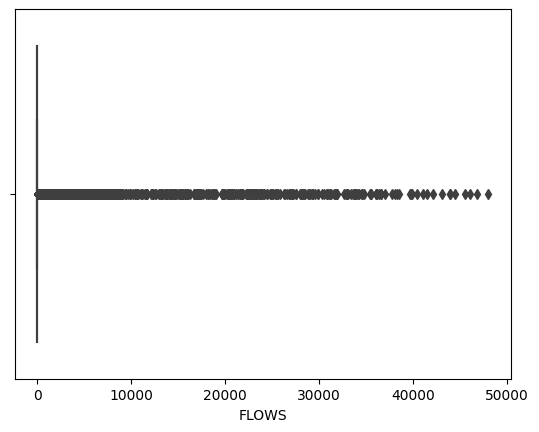

In [55]:
sns.boxplot(x=OD_final["FLOWS"])

In [49]:
OD_final.to_csv(path + 'OD_level7_nonwork_new.csv', index=False)

# **Test**

In [57]:
OD_subset = OD_final.copy()

In [58]:
OD_subset.drop(columns=['ORIGIN_CODE'], inplace=True)

In [ ]:
OD_subset

,DESTINATION_CODE,FLOWS
0,87194ac00ffffff,14496.0
1,87194ac01ffffff,736.0
2,87194ac02ffffff,483.0
3,87194ac03ffffff,1403.0
4,87194ac04ffffff,4255.0
...,...,...
172220,87195db5bffffff,0.0
172221,87195db5cffffff,46.0
172222,87195db5dffffff,0.0
172223,87195db69ffffff,161.0


In [59]:
# Grouping by 'DESTINATION_CODE' and summing the 'FLOWS' column
OD_subset = OD_subset.groupby('DESTINATION_CODE')['FLOWS'].sum().reset_index()

In [60]:
OD_subset= OD_subset.rename(columns={'DESTINATION_CODE': '_index'})

In [61]:
OD_subset['FLOWS'] = OD_subset['FLOWS'].astype(int)

In [62]:
OD_subset

,_index,FLOWS
0,87194ac00ffffff,34460
1,87194ac01ffffff,18106
2,87194ac02ffffff,11186
3,87194ac03ffffff,12333
4,87194ac04ffffff,42605
...,...,...
410,87195db5bffffff,20777
411,87195db5cffffff,1357
412,87195db5dffffff,2001
413,87195db69ffffff,4832


In [63]:
LDN = grid8

In [64]:
LDN

,_index,geometry,Centroids
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310)
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811)
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736)
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971)
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092)
...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377)
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413)
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499)
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204)


In [65]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
LDN_final = pd.merge(LDN, OD_subset, on= '_index', how= 'left')

In [66]:
LDN_final

,_index,geometry,Centroids,FLOWS
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310),34460
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811),18106
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736),11186
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971),12333
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092),42605
...,...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377),20777
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413),1357
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499),2001
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204),4832


# **POI**

In [67]:
#Points of Interest - London
POI = gpd.read_file(path + 'a0000000a.gdbtable', crs='epsg:4326')

In [68]:
POI_LC = POI.copy()

In [69]:
POI_LC

,ref_no,name,pointx_class,groupname,categoryname,classname,feature_easting,feature_northing,pos_accuracy,uprn,...,postcode,admin_boundary,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date,geometry
0,21864924,Bus Stop (Grove Farm Cottages),10590732,Transport,Bus Transport,Bus Stops,559498.0,184352.0,1,NaN,...,RM15,Thurrock,NaN,NaN,NaN,SMS Number,thuagwd,Department for Transport,2022-06-01,POINT (559498.000 184352.000)
1,20279522,Moat,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,531404.0,196330.0,2,NaN,...,EN2,Enfield London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2022-06-01,POINT (531404.000 196330.000)
2,20279821,Moat,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,524417.0,197646.0,2,NaN,...,EN5,Barnet London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2022-06-01,POINT (524417.000 197646.000)
3,20279822,Moat,03170245,Attractions,Historical and Cultural,Historic and Ceremonial Structures,525419.0,189921.0,2,NaN,...,N3,Barnet London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2022-06-01,POINT (525419.000 189921.000)
4,21859718,Bus Stop (Albion Terrace),10590732,Transport,Bus Transport,Bus Stops,537731.0,196190.0,1,NaN,...,E4,Epping Forest District,NaN,NaN,NaN,SMS Number,esxdgtdm,Department for Transport,2022-06-01,POINT (537731.000 196190.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342381,145881788,St Pauls Church Hall,06340456,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,522497.5,192819.0,1,200157006,...,NW7 1QU,Barnet London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2022-06-01,POINT (522497.500 192819.000)
342382,145881512,Abbey Community Centre,06340456,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,543777.0,184393.0,1,100055111,...,IG11 8LQ,Barking and Dagenham London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2022-06-01,POINT (543777.000 184393.000)
342383,145881660,Scouts,06350452,Public Infrastructure,Organisations,Youth Organisations,508075.0,186144.0,1,100023564302,...,UB10 8RE,Hillingdon London Boro,NaN,www.scouts.org.uk,The Scout Association,NaN,NaN,Ordnance Survey,2022-06-01,POINT (508075.000 186144.000)
342384,145881928,Brickfield Community Centre,06340456,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,517119.2,177291.2,1,10091692313,...,TW8 8JN,Hounslow London Boro,NaN,NaN,NaN,NaN,NaN,Ordnance Survey,2022-06-01,POINT (517119.200 177291.200)


In [70]:
# pick the columns that we need
POI_LC = POI_LC.loc[:,['groupname', 'geometry']]
POI_LC.columns

Index(['groupname', 'geometry'], dtype='object')

In [71]:
POI_LC

,groupname,geometry
0,Transport,POINT (559498.000 184352.000)
1,Attractions,POINT (531404.000 196330.000)
2,Attractions,POINT (524417.000 197646.000)
3,Attractions,POINT (525419.000 189921.000)
4,Transport,POINT (537731.000 196190.000)
...,...,...
342381,Public Infrastructure,POINT (522497.500 192819.000)
342382,Public Infrastructure,POINT (543777.000 184393.000)
342383,Public Infrastructure,POINT (508075.000 186144.000)
342384,Public Infrastructure,POINT (517119.200 177291.200)


In [72]:
# Spatial join the points to the polygons
POIHEX = gpd.sjoin(POI_LC, LDN, how='left', op='within')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [73]:
POIHEX

,groupname,geometry,index_right,_index,Centroids
0,Transport,POINT (559498.000 184352.000),181,87194e609ffffff,POINT (560279.301 183735.043)
1,Attractions,POINT (531404.000 196330.000),403,87195db4bffffff,POINT (532017.262 195382.750)
2,Attractions,POINT (524417.000 197646.000),409,87195db5affffff,POINT (524569.362 198778.796)
3,Attractions,POINT (525419.000 189921.000),307,87195da44ffffff,POINT (526040.981 190657.222)
4,Transport,POINT (537731.000 196190.000),241,87194e6b0ffffff,POINT (538723.708 196046.457)
...,...,...,...,...,...
342381,Public Infrastructure,POINT (522497.500 192819.000),348,87195da73ffffff,POINT (522314.675 192355.238)
342382,Public Infrastructure,POINT (543777.000 184393.000),210,87194e688ffffff,POINT (543169.627 184093.047)
342383,Public Infrastructure,POINT (508075.000 186144.000),356,87195dac2ffffff,POINT (507357.928 186733.804)
342384,Public Infrastructure,POINT (517119.200 177291.200),170,87194adb3ffffff,POINT (517046.263 177347.269)


In [74]:
# Reset the index to have the points indexed by the polygons' index
POIHEX = POIHEX.reset_index(drop=True)

#  drop columns

LeisureCare = POIHEX.drop(['index_right'], axis=1)

LeisureCare

,groupname,geometry,_index,Centroids
0,Transport,POINT (559498.000 184352.000),87194e609ffffff,POINT (560279.301 183735.043)
1,Attractions,POINT (531404.000 196330.000),87195db4bffffff,POINT (532017.262 195382.750)
2,Attractions,POINT (524417.000 197646.000),87195db5affffff,POINT (524569.362 198778.796)
3,Attractions,POINT (525419.000 189921.000),87195da44ffffff,POINT (526040.981 190657.222)
4,Transport,POINT (537731.000 196190.000),87194e6b0ffffff,POINT (538723.708 196046.457)
...,...,...,...,...
342381,Public Infrastructure,POINT (522497.500 192819.000),87195da73ffffff,POINT (522314.675 192355.238)
342382,Public Infrastructure,POINT (543777.000 184393.000),87194e688ffffff,POINT (543169.627 184093.047)
342383,Public Infrastructure,POINT (508075.000 186144.000),87195dac2ffffff,POINT (507357.928 186733.804)
342384,Public Infrastructure,POINT (517119.200 177291.200),87194adb3ffffff,POINT (517046.263 177347.269)


In [75]:
#  drop columns

df_LeisureCare = LeisureCare.drop(['geometry'], axis=1)

# Pivot the DataFrame
df_LeisureCare = df_LeisureCare.pivot_table(index='_index', columns='groupname', aggfunc='size', fill_value=0)

#  drop columns

#df_LeisureCare = df_LeisureCare.drop(['Manufacturing and Production', 'Public Infrastructure', 'Transport','Commercial Services'], axis=1)

# Set '_index' as the first column
df_LeisureCare.reset_index(inplace=True)

df_LeisureCare

groupname,_index,"Accommodation, Eating and Drinking",Attractions,Commercial Services,Education and Health,Manufacturing and Production,Public Infrastructure,Retail,Sport and Entertainment,Transport
0,87194ac00ffffff,51,9,193,66,34,115,69,24,87
1,87194ac01ffffff,12,12,75,26,4,56,11,6,51
2,87194ac02ffffff,9,4,61,10,9,38,13,11,46
3,87194ac03ffffff,4,16,21,5,4,37,7,5,43
4,87194ac04ffffff,54,11,180,79,14,119,56,31,74
...,...,...,...,...,...,...,...,...,...,...
397,87195db5bffffff,42,11,171,50,23,87,40,21,81
398,87195db5cffffff,0,0,0,1,0,7,0,0,2
399,87195db5dffffff,1,1,9,1,4,13,5,2,9
400,87195db69ffffff,1,1,7,0,7,11,5,0,13


In [78]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
features = pd.merge(OD_subset, df_LeisureCare, on= '_index', how= 'left').fillna(0)
features

,_index,FLOWS,"Accommodation, Eating and Drinking",Attractions,Commercial Services,Education and Health,Manufacturing and Production,Public Infrastructure,Retail,Sport and Entertainment,Transport
0,87194ac00ffffff,34460,51.0,9.0,193.0,66.0,34.0,115.0,69.0,24.0,87.0
1,87194ac01ffffff,18106,12.0,12.0,75.0,26.0,4.0,56.0,11.0,6.0,51.0
2,87194ac02ffffff,11186,9.0,4.0,61.0,10.0,9.0,38.0,13.0,11.0,46.0
3,87194ac03ffffff,12333,4.0,16.0,21.0,5.0,4.0,37.0,7.0,5.0,43.0
4,87194ac04ffffff,42605,54.0,11.0,180.0,79.0,14.0,119.0,56.0,31.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...
410,87195db5bffffff,20777,42.0,11.0,171.0,50.0,23.0,87.0,40.0,21.0,81.0
411,87195db5cffffff,1357,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,2.0
412,87195db5dffffff,2001,1.0,1.0,9.0,1.0,4.0,13.0,5.0,2.0,9.0
413,87195db69ffffff,4832,1.0,1.0,7.0,0.0,7.0,11.0,5.0,0.0,13.0


In [79]:
# Rename Columns

features = features.rename(columns={
                          'Accommodation, Eating and Drinking' : 'AED',
                          'Attractions' : 'AT',
                          'Commercial Services' : 'CS',
                          'Education and Health' : 'EH',
                          'Manufacturing and Production' : 'MP',
                          'Public Infrastructure' : 'PI',
                          'Retail' : 'RT',
                          'Sport and Entertainment' : 'SE',
                          'Transport' : 'TR',
                          })

In [80]:
# Columns to convert from float to integer
columns_to_convert = ['AED', 'AT', 'CS', 'EH', 'MP', 'PI', 'RT', 'SE', 'TR']

# Loop through the columns and convert their data types
for col in columns_to_convert:
    features[col] = features[col].astype(int)


In [81]:
#  drop columns

POI_work = features.drop(['AED', 'CS', 'MP', 'TR', 'SE'], axis=1)


In [82]:
POI_work

,_index,FLOWS,AT,EH,PI,RT
0,87194ac00ffffff,34460,9,66,115,69
1,87194ac01ffffff,18106,12,26,56,11
2,87194ac02ffffff,11186,4,10,38,13
3,87194ac03ffffff,12333,16,5,37,7
4,87194ac04ffffff,42605,11,79,119,56
...,...,...,...,...,...,...
410,87195db5bffffff,20777,11,50,87,40
411,87195db5cffffff,1357,0,1,7,0
412,87195db5dffffff,2001,1,1,13,5
413,87195db69ffffff,4832,1,0,11,5


In [83]:
# List of columns to be summed
columns_to_sum = ['AT', 'EH', 'RT', 'PI']

# Create the new column 'all' by summing the values of the specified columns
POI_work['all'] = POI_work[columns_to_sum].sum(axis=1)


# Move the 'all' column to position 1
all_column = POI_work.pop('all')
POI_work.insert(1, 'all', all_column)

In [84]:
#  drop columns

POI_work = POI_work.drop(['FLOWS', 'AT', 'EH', 'RT', 'PI'], axis=1)

In [85]:
POI_work

,_index,all
0,87194ac00ffffff,259
1,87194ac01ffffff,105
2,87194ac02ffffff,65
3,87194ac03ffffff,65
4,87194ac04ffffff,265
...,...,...
410,87195db5bffffff,188
411,87195db5cffffff,8
412,87195db5dffffff,20
413,87195db69ffffff,17


In [86]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
LDN_final = pd.merge(LDN_final, POI_work, on= '_index', how= 'left')

In [87]:
LDN_final

,_index,geometry,Centroids,FLOWS,all
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310),34460,259
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811),18106,105
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736),11186,65
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971),12333,65
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092),42605,265
...,...,...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377),20777,188
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413),1357,8
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499),2001,20
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204),4832,17


In [89]:
#set

#setup the font
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

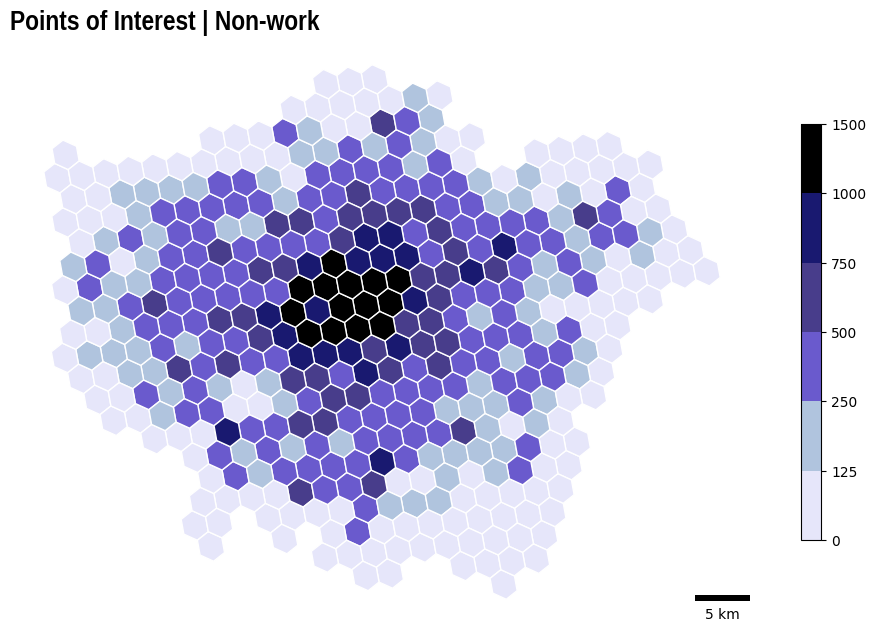

In [90]:
#transform london to BNG
LDN_final.to_crs("EPSG:27700", inplace = True)

# plot
fig, ax = plt.subplots(1,1, figsize=(12,9))

# scalebar
divider = make_axes_locatable(ax)
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# create discrete colormap
cmap = colors.ListedColormap(['lavender','lightsteelblue','slateblue','darkslateblue','midnightblue', 'Black'])
bounds = [0,125,250,500,750,1000,1500]
norm = colors.BoundaryNorm(bounds, cmap.N)

#We can check that this has occured by plotting the results
LDN_final.plot(ax=ax, column='all', cmap=cmap, norm=norm, legend=True,edgecolor='white',legend_kwds={'shrink': 0.6})


plt.axis('off')
plt.title("Points of Interest | Non-work", loc='left', size=20,**tfont)
plt.savefig(path + "images/POI_nonwork.png", bbox_inches = 'tight')

In [91]:
POI_work.to_csv(path + 'POI_nonwork7_new.csv', index=False)

In [92]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
 2   AED     415 non-null    int64 
 3   AT      415 non-null    int64 
 4   CS      415 non-null    int64 
 5   EH      415 non-null    int64 
 6   MP      415 non-null    int64 
 7   PI      415 non-null    int64 
 8   RT      415 non-null    int64 
 9   SE      415 non-null    int64 
 10  TR      415 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 38.9+ KB


# **Sanity Check**

In [ ]:
#set

#setup the font
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

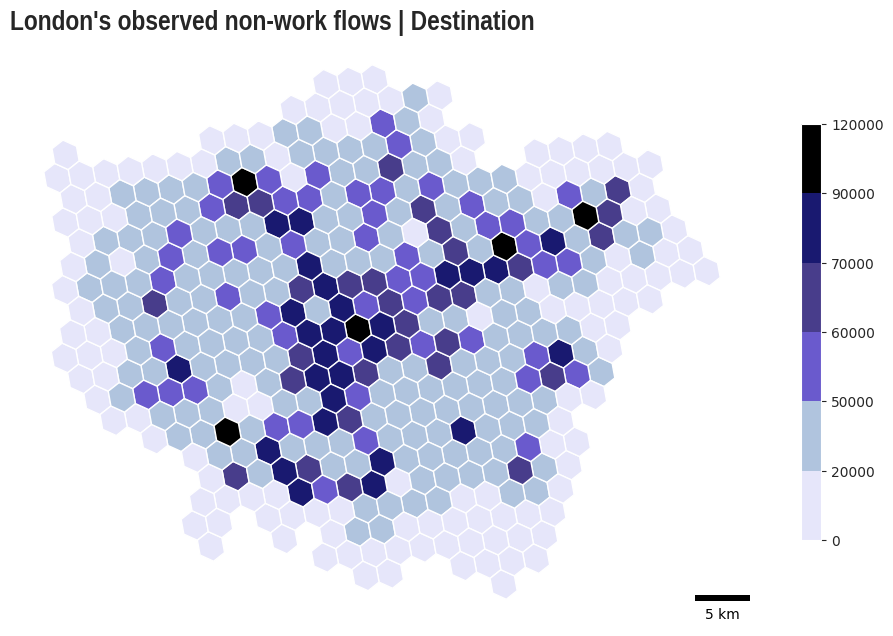

In [ ]:
#transform london to BNG
LDN_final.to_crs("EPSG:27700", inplace = True)

# plot
fig, ax = plt.subplots(1,1, figsize=(12,9))

# scalebar
divider = make_axes_locatable(ax)
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# create discrete colormap
cmap = colors.ListedColormap(['lavender','lightsteelblue','slateblue','darkslateblue','midnightblue', 'Black'])
bounds = [0,20000,50000,60000,70000,90000,120000]
norm = colors.BoundaryNorm(bounds, cmap.N)

#We can check that this has occured by plotting the results
LDN_final.plot(ax=ax, column='FLOWS', cmap=cmap, norm=norm, legend=True,edgecolor='white',legend_kwds={'shrink': 0.6})


plt.axis('off')
plt.title("London's observed non-work flows | Destination", loc='left', size=20,**tfont)
plt.savefig(path + "images/Hex_nonwork_observed.png", bbox_inches = 'tight')

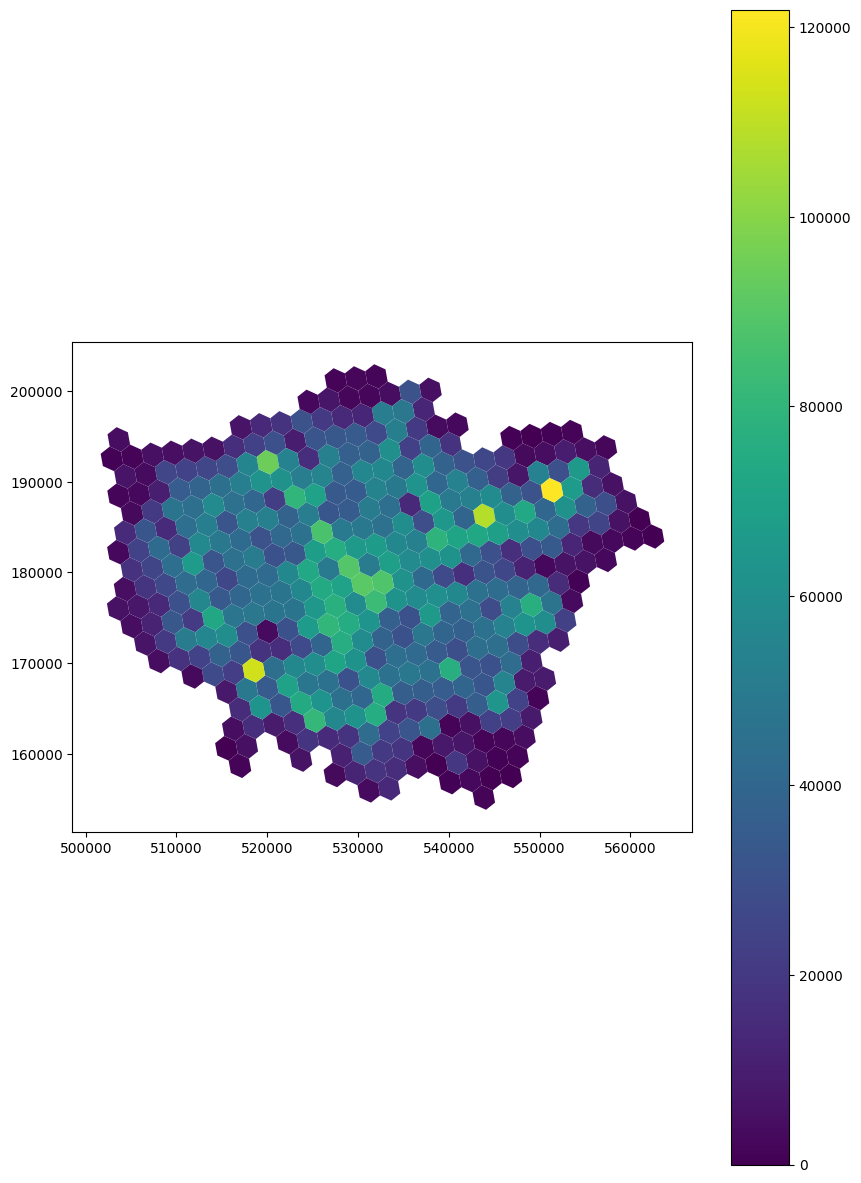

In [ ]:
#transform london to BNG
LDN_final.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
LDN_final.plot(figsize = (10,15), column='FLOWS', legend=True)
plt.show()

In [ ]:
flows = OD_final

In [ ]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.6+ KB


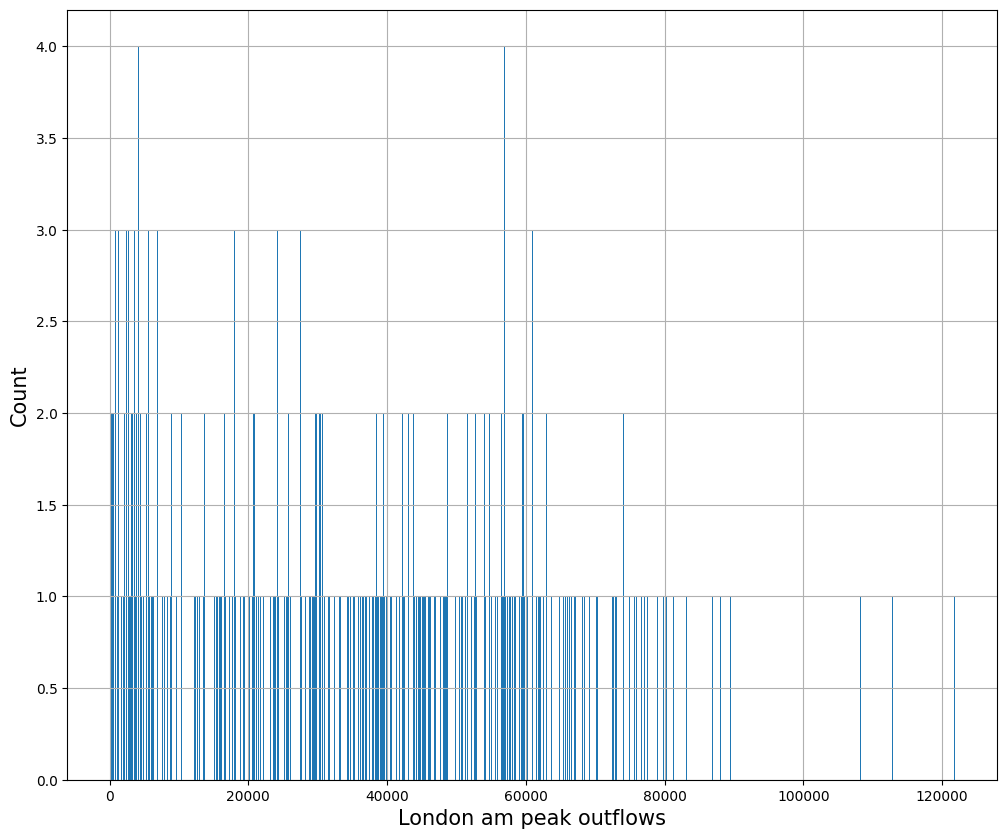

In [ ]:

# Assuming your DataFrame is named 'df' and the 'FLOWS' column is converted to integer data type
bin_size = 100

# Extract the 'FLOWS' column from the DataFrame
flows = flows['FLOWS']

# Create a histogram plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.hist(flows, bins=int(flows.max() / bin_size))
plt.xlabel('London am peak outflows', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(True)
plt.show()


In [ ]:
OD_final

,_index,FLOWS
0,87194ac00ffffff,34460
1,87194ac01ffffff,18106
2,87194ac02ffffff,11186
3,87194ac03ffffff,12333
4,87194ac04ffffff,42605
...,...,...
410,87195db5bffffff,20777
411,87195db5cffffff,1357
412,87195db5dffffff,2001
413,87195db69ffffff,4832


In [ ]:
# Calculate statistics for the "FLOWS" column
statistics = {
    'N': OD_final['FLOWS'].count(),
    'mean': OD_final['FLOWS'].mean(),
    'minimum': OD_final['FLOWS'].min(),
    'maximum': OD_final['FLOWS'].max(),
    'std_deviation': OD_final['FLOWS'].std(),
    'variance': OD_final['FLOWS'].var()
}

# Create a new DataFrame from the statistics dictionary
statistics_df = pd.DataFrame(statistics, index=['FLOWS'])
statistics_df

,N,mean,minimum,maximum,std_deviation,variance
FLOWS,415,34394.93494,0,121843,23964.929631,5.743179e+08


<Axes: xlabel='FLOWS', ylabel='Count'>

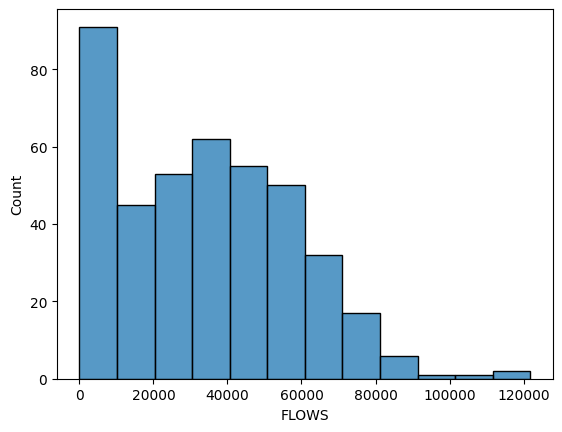

In [ ]:
# A normal plot
sns.histplot(data=OD_final, x="FLOWS")

In [ ]:
# Assuming OD_final is your DataFrame
new_data = OD_final[OD_final["FLOWS"] > 0]

In [ ]:
# Remove rows with zero values in the 'FLOWS' column
#new_data = new_data[new_data['FLOWS'] != 0]

In [ ]:
# Calculate statistics for the "FLOWS" column
statistics = {
    'N': new_data['FLOWS'].count(),
    'mean': new_data['FLOWS'].mean(),
    'minimum': new_data['FLOWS'].min(),
    'maximum': new_data['FLOWS'].max(),
    'std_deviation': new_data['FLOWS'].std(),
    'variance': new_data['FLOWS'].var()
}

# Create a new DataFrame from the statistics dictionary
statistics_df = pd.DataFrame(statistics, index=['FLOWS'])
statistics_df

,N,mean,minimum,maximum,std_deviation,variance
FLOWS,414,34478.014493,92,121843,23934.015515,5.728371e+08


<Axes: xlabel='FLOWS', ylabel='Count'>

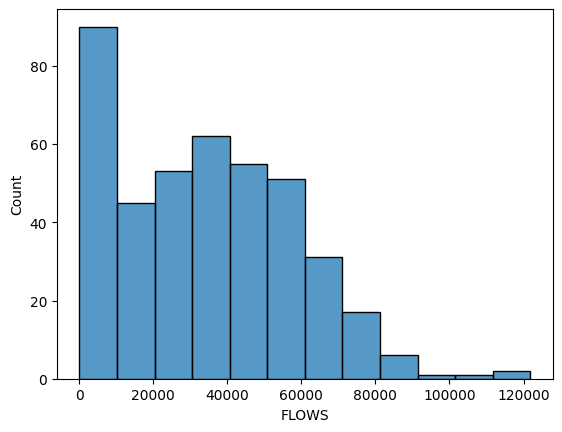

In [ ]:
# A normal plot
sns.histplot(data=new_data, x="FLOWS")

<Axes: xlabel='FLOWS', ylabel='Count'>

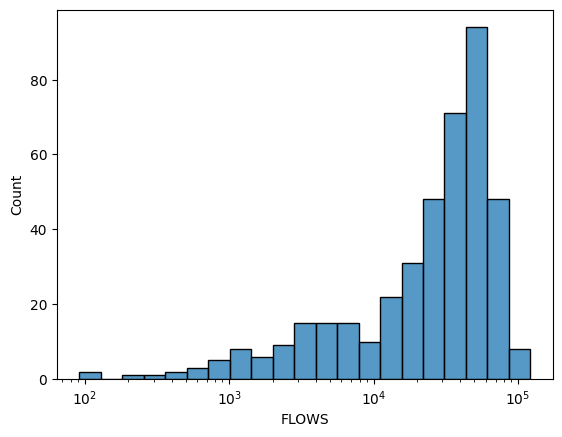

In [ ]:
# A plot with log values, for large datasets
sns.histplot(data=new_data, x="FLOWS", log_scale=True)


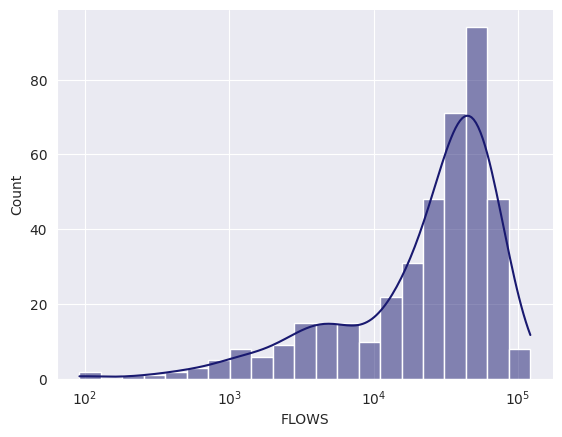

In [ ]:
#A plot whith a line to se the distribution
sns.set_style("darkgrid")
sns.histplot(data=new_data, x="FLOWS", kde=True, log_scale=True, color='midnightblue')
sns.despine()
plt.savefig(path + "images/histogram_nonwork.png", dpi=300)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
 2   AED     415 non-null    int64 
 3   AT      415 non-null    int64 
 4   CS      415 non-null    int64 
 5   EH      415 non-null    int64 
 6   MP      415 non-null    int64 
 7   PI      415 non-null    int64 
 8   RT      415 non-null    int64 
 9   SE      415 non-null    int64 
 10  TR      415 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 38.9+ KB


In [ ]:
# This performs a multiple regression of wellbeing against greenery:

school_pop = smf.ols(formula='FLOWS ~ AED + AT + CS + EH + MP + PI + RT + SE + TR',data=features).fit()

# And this gives a big summary of the results:
print(school_pop.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     162.0
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          2.66e-128
Time:                        11:45:33   Log-Likelihood:                -4456.7
No. Observations:                 415   AIC:                             8933.
Df Residuals:                     405   BIC:                             8974.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5642.0168   1043.614      5.406      0.0

In [ ]:
# This performs a multiple regression of wellbeing against greenery:

school_pop = smf.ols(formula='FLOWS ~ AED + AT + EH + MP + PI + RT + TR',data=features).fit()

# And this gives a big summary of the results:
print(school_pop.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     208.8
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          1.94e-130
Time:                        15:15:28   Log-Likelihood:                -4457.1
No. Observations:                 415   AIC:                             8930.
Df Residuals:                     407   BIC:                             8962.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5655.2406   1030.797      5.486      0.0

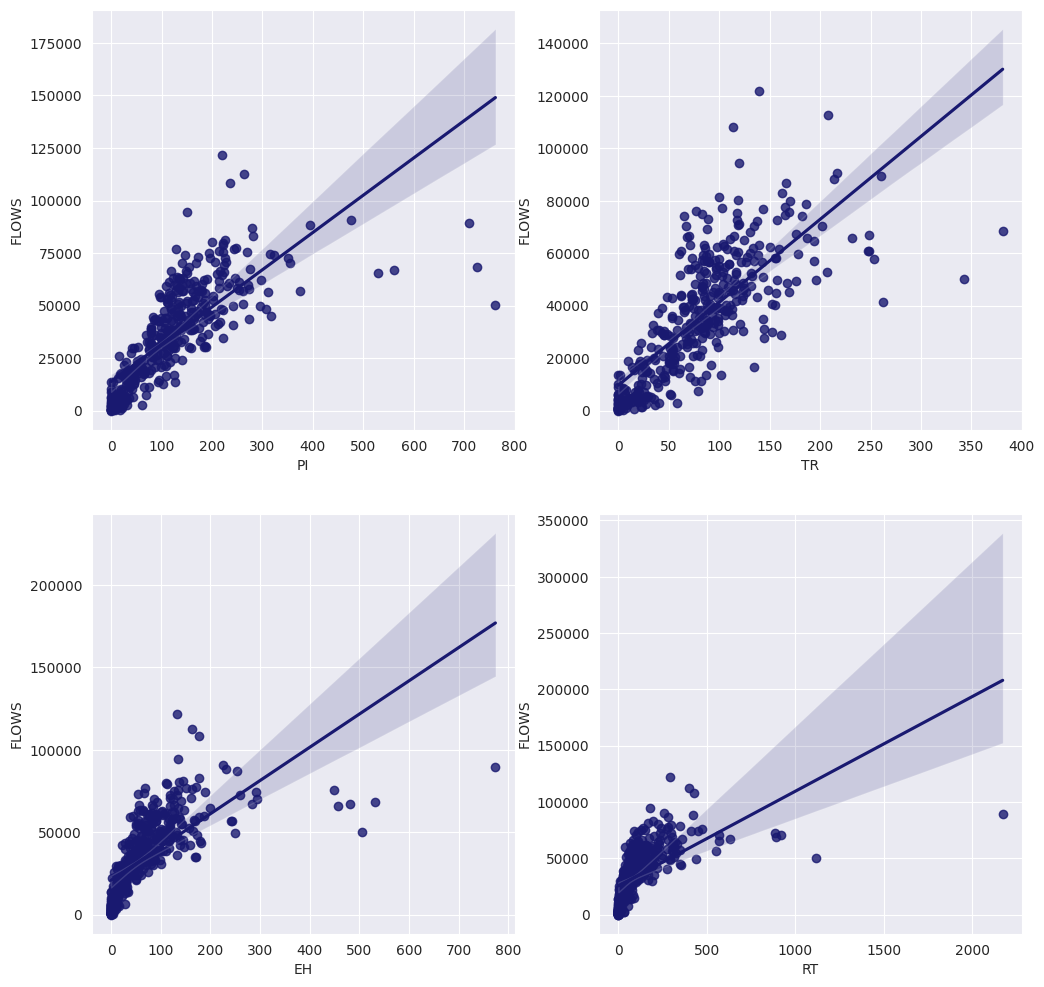

In [ ]:
f = plt.figure(figsize=(12, 12))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.regplot(x="PI", y="FLOWS", data=features, color='midnightblue')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.regplot(x="TR", y="FLOWS", data=features, color='midnightblue')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.regplot(x="EH", y="FLOWS", data=features, color='midnightblue')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.regplot(x="RT", y="FLOWS", data=features, color='midnightblue')

plt.savefig(path + "images/regression_nonwork.png")

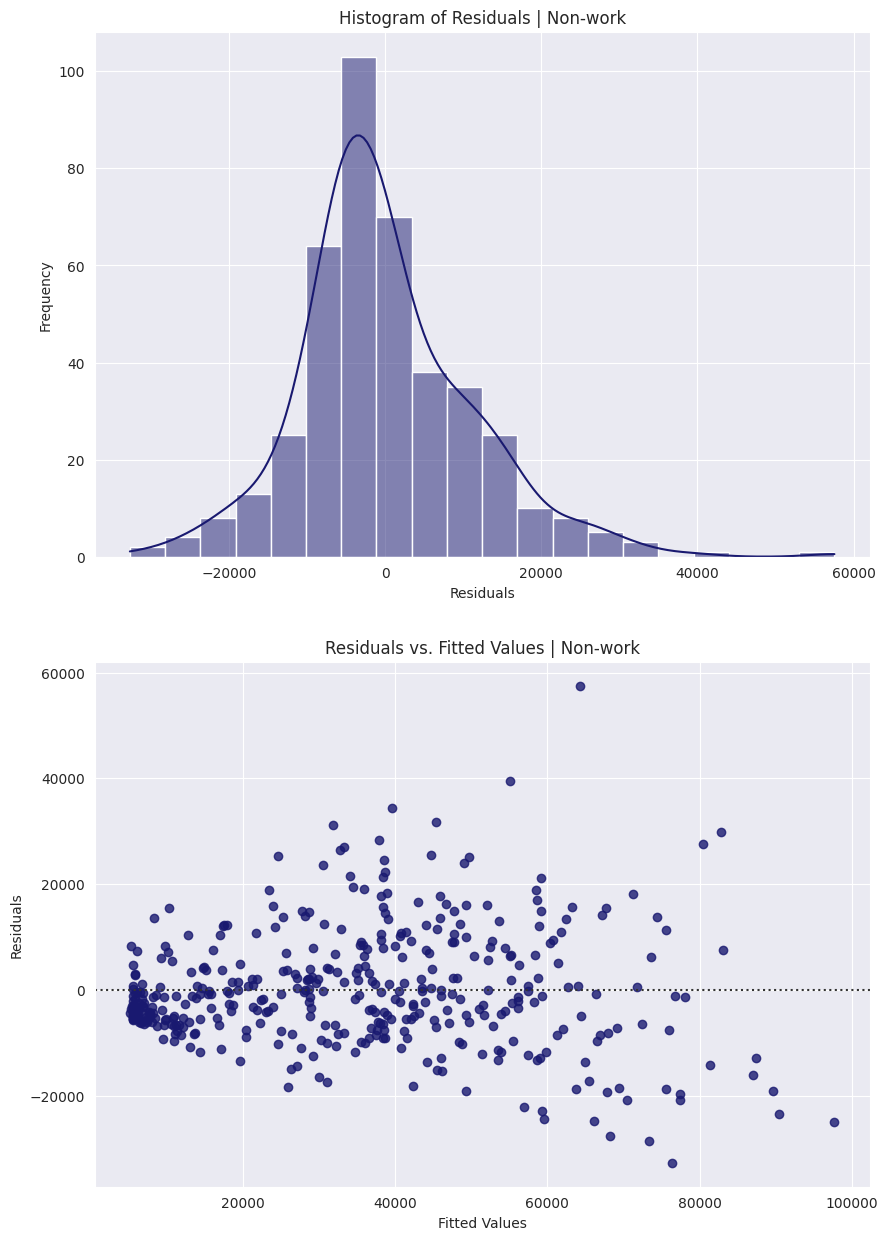

In [ ]:
# Get the residuals from your regression model
residuals = school_pop.resid

#plot
f = plt.figure(figsize=(10, 15))
gs = f.add_gridspec(2, 1)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.histplot(residuals, kde=True, color='midnightblue', bins=20)
    plt.title('Histogram of Residuals | Non-work')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.residplot(x=school_pop.fittedvalues, y=residuals, color='midnightblue')
    plt.title('Residuals vs. Fitted Values | Non-work')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

plt.savefig(path + "images/Residuals_nonwork.png")

In [ ]:
# This performs a multiple regression of wellbeing against greenery:

school_pop = smf.ols(formula='FLOWS ~ PI',data=features).fit()

# And this gives a big summary of the results:
print(school_pop.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     586.1
Date:                Fri, 01 Sep 2023   Prob (F-statistic):           3.02e-81
Time:                        11:38:21   Log-Likelihood:                -4590.0
No. Observations:                 415   AIC:                             9184.
Df Residuals:                     413   BIC:                             9192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.383e+04   1137.865     12.157      0.0

In [ ]:
# Pick out some values of interest and print the regression equation: y=mx+c or y=beta_1*x + beta_0

# The order of results: intercept term, slope term
beta_0, beta_1 = school_pop.params
rsq    = school_pop.rsquared
pval_0, pval_1 = school_pop.pvalues

print("y =", round(beta_1,3), "x +", round(beta_0,3))
print("R^2 = ", rsq)
print("p-value of greenery = ", round(pval_1,5))
print("p-value of intercept = ", round(pval_0,5))

y = 177.398 x + 13833.029
R^2 =  0.586646018345077
p-value of greenery =  0.0
p-value of intercept =  0.0


y = 177.398 x + 13833.029
Rsq =  0.586646018345077
p-value of Population =  3.015078949573256e-81


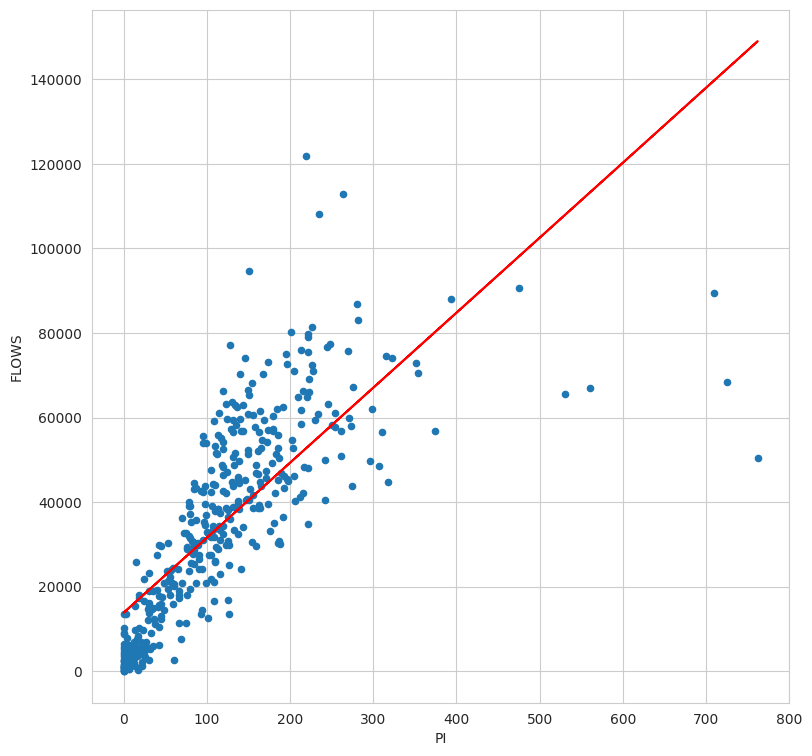

In [ ]:
# plot the result
fig, ax = plt.subplots()
features.plot(kind='scatter', x='PI', y='FLOWS', figsize=(9, 9), ax = ax)

X=features.PI
b = plt.plot(X, X*beta_1 + beta_0, 'r') # Plot the regression line.

print("y =", round(beta_1,3), "x +", round(beta_0,3))
print("Rsq = ", rsq)
print("p-value of Population = ", pval_1)

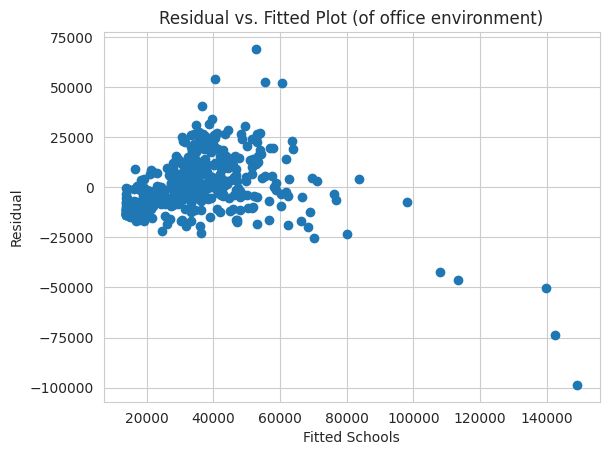

In [ ]:
# plot
plt.scatter(school_pop.fittedvalues, school_pop.resid)
# adding title and labels
plt.xlabel('Fitted Schools')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot (of office environment)')
plt.show()

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
 2   AED     415 non-null    int64 
 3   AT      415 non-null    int64 
 4   CS      415 non-null    int64 
 5   EH      415 non-null    int64 
 6   MP      415 non-null    int64 
 7   PI      415 non-null    int64 
 8   RT      415 non-null    int64 
 9   SE      415 non-null    int64 
 10  TR      415 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 38.9+ KB


<Axes: xlabel='TR', ylabel='FLOWS'>

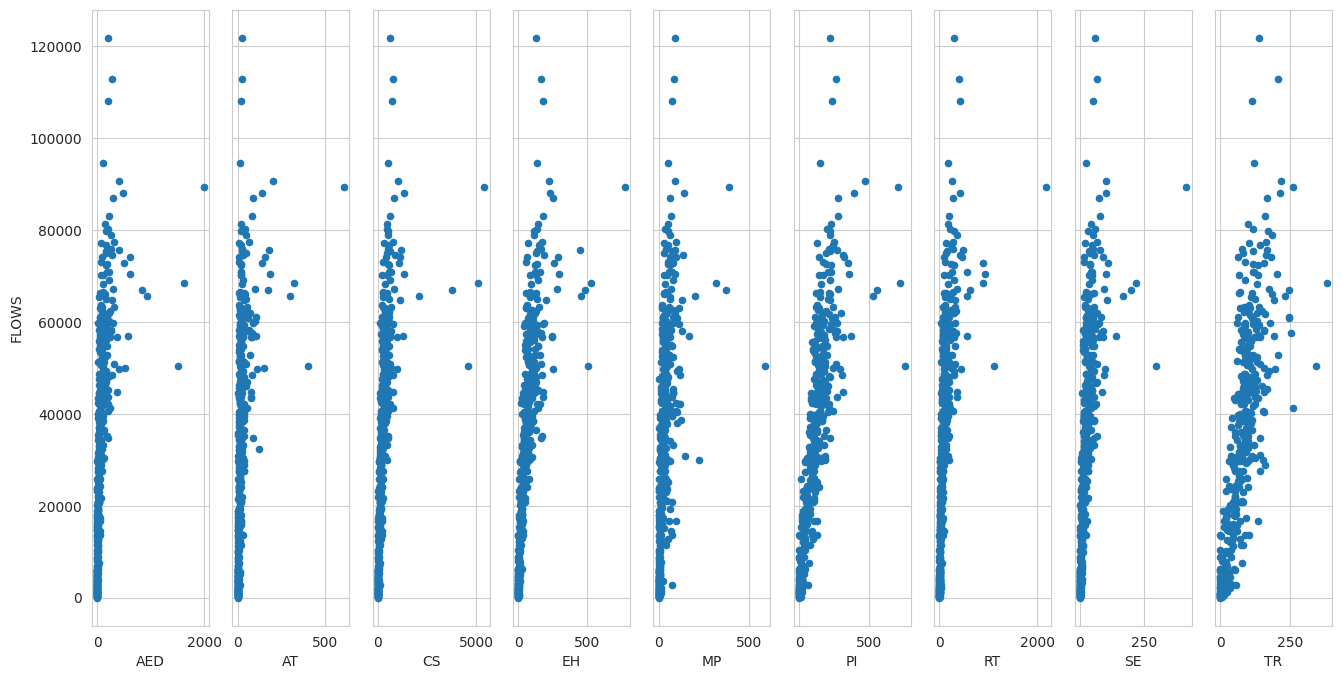

In [ ]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 9, sharey=True)
features.plot(kind='scatter', x='AED', y='FLOWS', ax=axs[0], figsize=(16, 8))
features.plot(kind='scatter', x='AT', y='FLOWS', ax=axs[1])
features.plot(kind='scatter', x='CS', y='FLOWS', ax=axs[2])
features.plot(kind='scatter', x='EH', y='FLOWS', ax=axs[3])
features.plot(kind='scatter', x='MP', y='FLOWS', ax=axs[4])
features.plot(kind='scatter', x='PI', y='FLOWS', ax=axs[5])
features.plot(kind='scatter', x='RT', y='FLOWS', ax=axs[6])
features.plot(kind='scatter', x='SE', y='FLOWS', ax=axs[7])
features.plot(kind='scatter', x='TR', y='FLOWS', ax=axs[8])

In [ ]:
# This performs a multiple regression of expectancy against recycling:

reg_ac = smf.ols(formula='FLOWS ~ AED + AT + CS + EH + MP + PI + RT + SE + TR',data=features).fit()

# And this gives a big summary of the results:
print(reg_ac.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     162.0
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          2.66e-128
Time:                        11:26:23   Log-Likelihood:                -4456.7
No. Observations:                 415   AIC:                             8933.
Df Residuals:                     405   BIC:                             8974.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5642.0168   1043.614      5.406      0.0

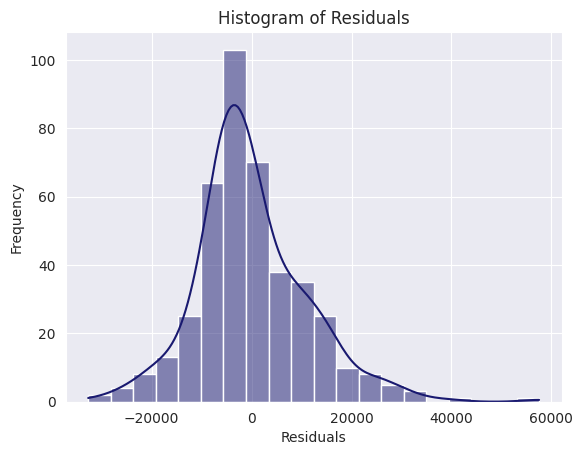

In [ ]:
# Get the residuals from your regression model
residuals = school_pop.resid

# Create a histogram of the residuals
plt.figure()
sns.histplot(residuals, kde=True, color='midnightblue', bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Residuals')

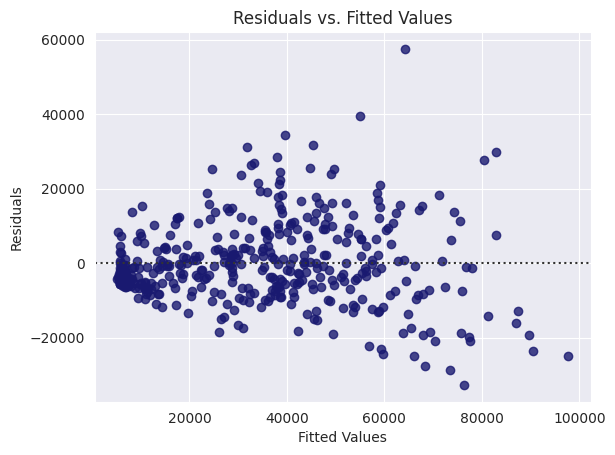

In [ ]:
sns.residplot(x=school_pop.fittedvalues, y=residuals, color='midnightblue')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

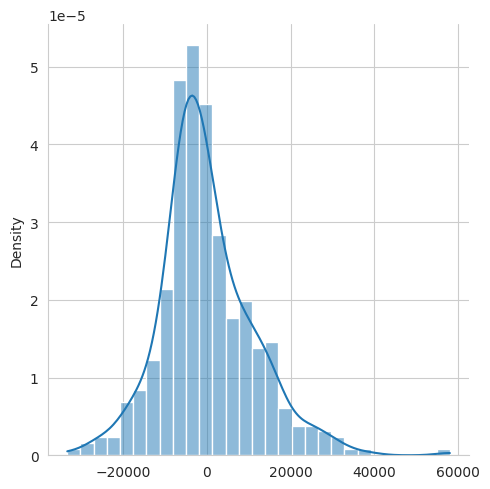

In [ ]:
#the residuals are normally distributed or not.

sn.displot(reg_ac.resid, stat="density", kde = True)